In [38]:
import uproot 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px


In [39]:
my_tuple = uproot.open("Lb2JpsiLambda_yz_tuple.root:Hlt2DetachedJpsiTuple/Tuple")

In [40]:
my_tuple.keys()

['EVENTNUMBER',
 'Hlt2DetachedJpsiDecision',
 'Hlt2_TCK',
 'RUNNUMBER',
 'Lb_END_VZ',
 'Lb_END_VX',
 'Lb_END_VY',
 'Lb_END_VRHO',
 'Lb_BPVCORRM',
 'Lb_BPVDIRA',
 'Lb_BPVETA',
 'Lb_BPVIPCHI2',
 'Lb_BPVFDCHI2',
 'Lb_BPVLTIME',
 'Lb_BPVFD',
 'Lb_BPVFDIRX',
 'Lb_BPVFDIRY',
 'Lb_BPVFDIRZ',
 'Lb_BPVFDVECX',
 'Lb_BPVFDVECY',
 'Lb_BPVFDVECZ',
 'Lb_BPVIP',
 'Lb_BPVVDRHO',
 'Lb_BPVVDX',
 'Lb_BPVVDY',
 'Lb_BPVVDZ',
 'Lb_COMB_MASS',
 'Lb_MAXDOCA',
 'Lb_MAXDOCACHI2',
 'Lb_MAXSDOCA',
 'Lb_MAXSDOCACHI2',
 'Lb_TRUEID',
 'Lb_TRUEKEY',
 'Lb_TRUEPT',
 'Lb_TRUEPX',
 'Lb_TRUEPY',
 'Lb_TRUEPZ',
 'Lb_TRUEENERGY',
 'Lb_TRUEP',
 'Lb_TRUEFOURMOMENTUME',
 'Lb_TRUEFOURMOMENTUMX',
 'Lb_TRUEFOURMOMENTUMY',
 'Lb_TRUEFOURMOMENTUMZ',
 'Lb_TRUEORIGINVZ',
 'Lb_TRUEORIGINVX',
 'Lb_TRUEORIGINVY',
 'Lb_TRUEENDVZ',
 'Lb_TRUEENDVX',
 'Lb_TRUEENDVY',
 'Lb_BKGCAT',
 'Lb_MC_MOTHER_ID',
 'Lb_MC_MOTHER_KEY',
 'Lb_MC_GD_MOTHER_ID',
 'Lb_MC_GD_MOTHER_KEY',
 'Lb_MC_GD_GD_MOTHER_ID',
 'Lb_MC_GD_GD_MOTHER_KEY',
 'Lb_MASS',
 'Lb_P',
 '

In [41]:
#keys = my_tuple.keys()
keys = ["Jpsi_PT","Lambda0_END_VRHO","Lambda0_BPVDIRA","Lambda0_BPVIP","Lambda0_BPVIPCHI2","Lambda0_MASS","Lb_BPVDIRA","Lb_BPVIP","Lb_BPVVDRHO","Lb_MAXSDOCA","Lb_P","Lb_PT","Lb_CHI2","Lambda0_TRUEENDVZ","Lb_BKGCAT","p_plus_PID_P","p_plus_PID_K","p_plus_MINIP","p_plus_P","p_plus_PT","pi_minus_P","pi_minus_PT"]

In [42]:
signal_data = my_tuple.arrays(keys,library="pd", cut="(Lb_BKGCAT==0)&(Lambda0_TRUEENDVZ > 2500)")
bg_data = my_tuple.arrays(keys,library="pd", cut="(Lb_BKGCAT!=0)|(Lambda0_TRUEENDVZ < 2500)")

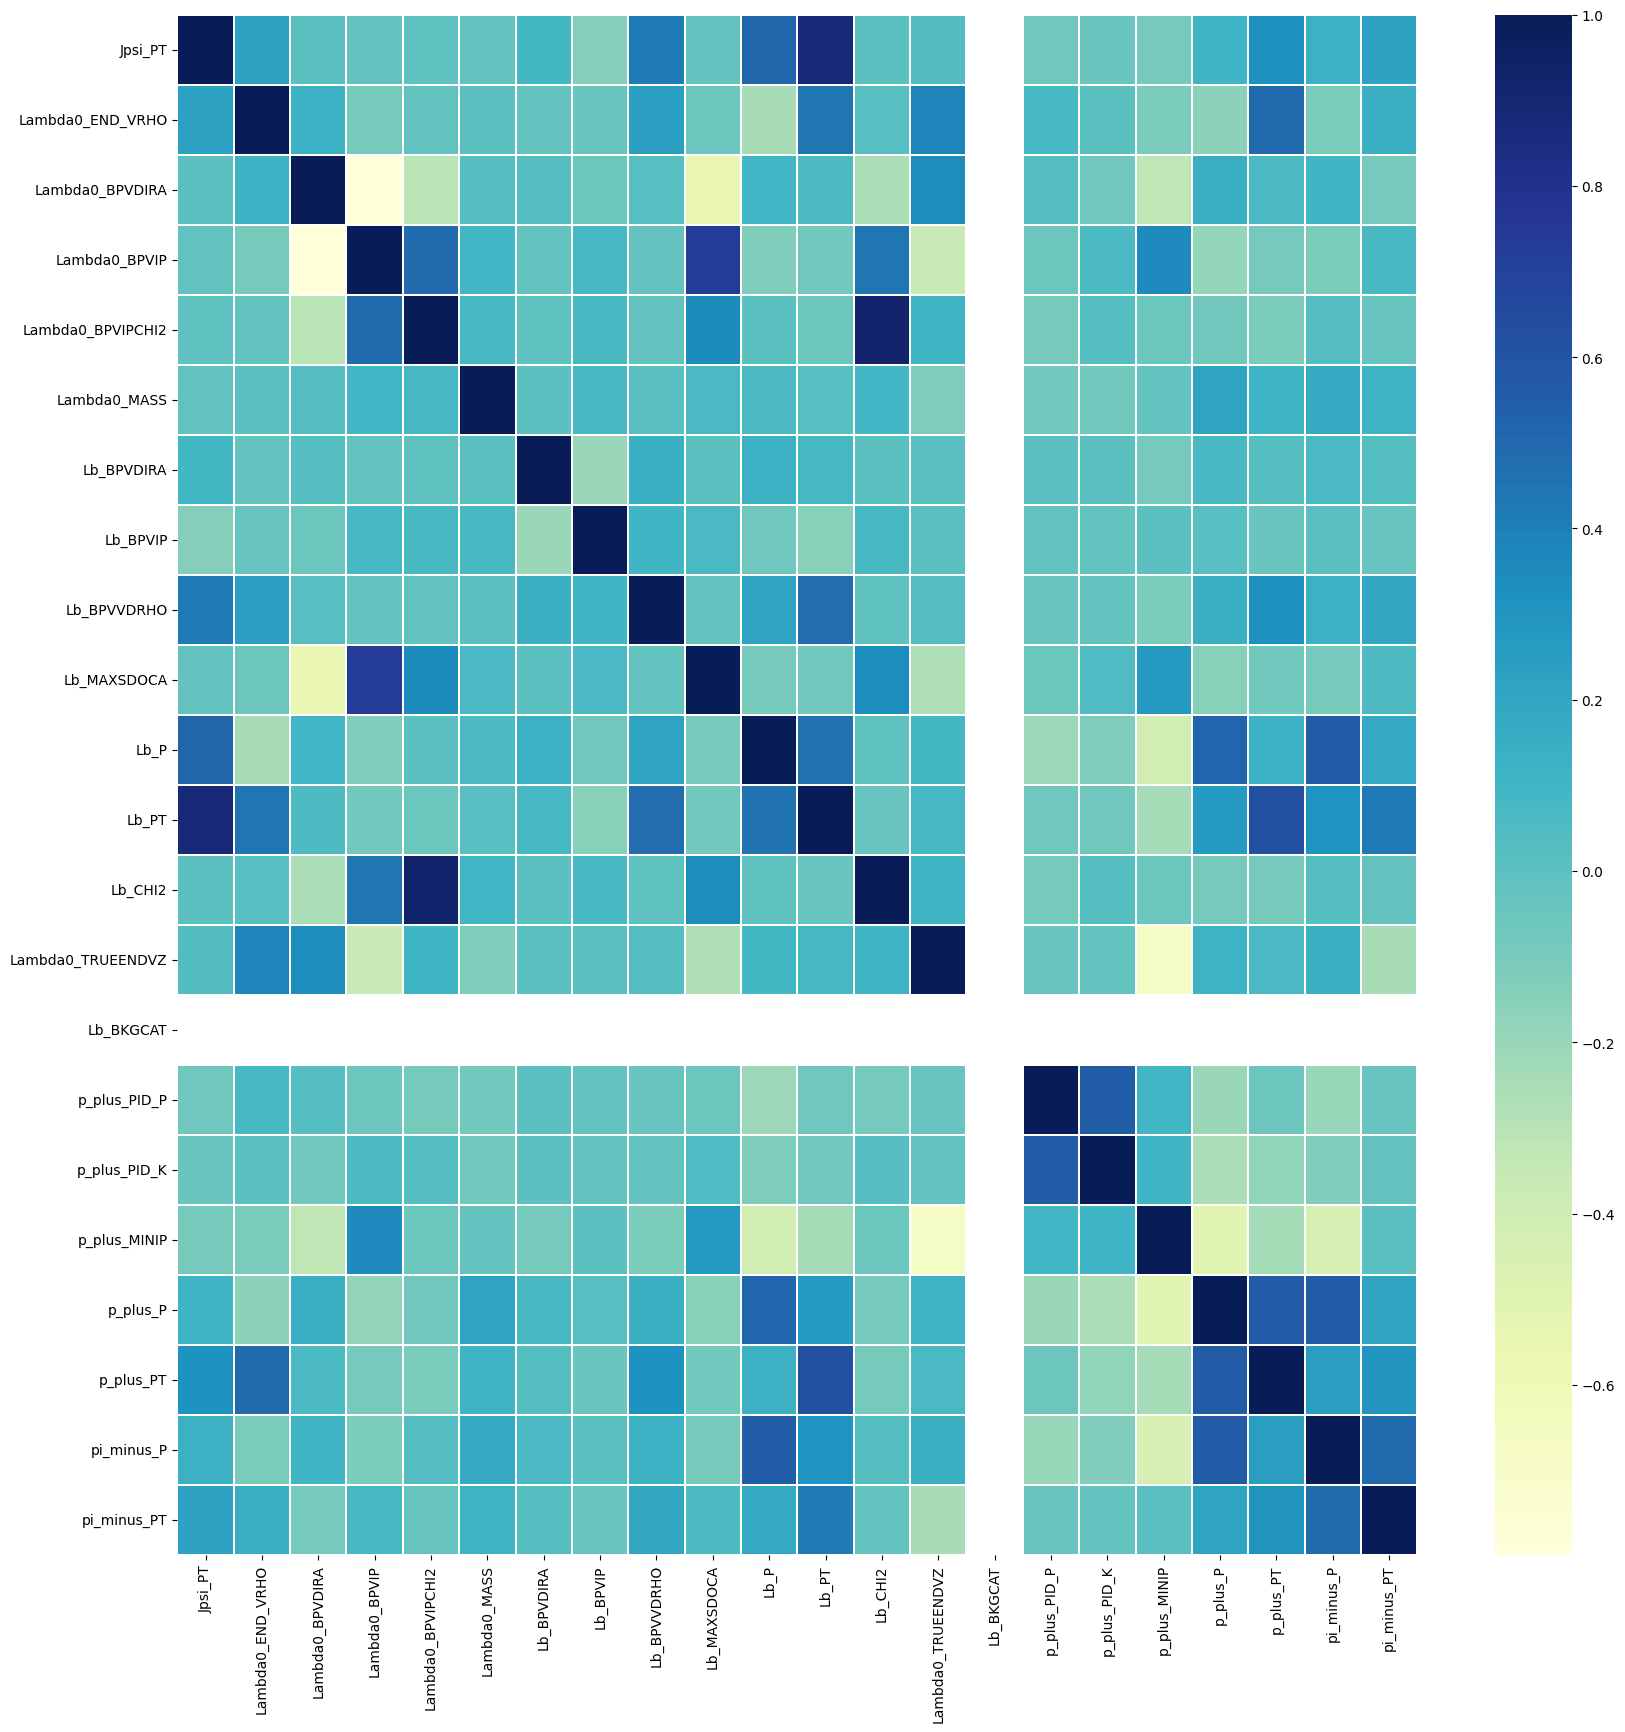

In [43]:
f, ax = plt.subplots(figsize =(20, 20))
sns.heatmap(signal_data.corr(), ax = ax, cmap ="YlGnBu", linewidths = 0.1)
plt.show()

In [44]:
bg_data

,Jpsi_PT,Lambda0_END_VRHO,Lambda0_BPVDIRA,Lambda0_BPVIP,Lambda0_BPVIPCHI2,Lambda0_MASS,Lb_BPVDIRA,Lb_BPVIP,Lb_BPVVDRHO,Lb_MAXSDOCA,...,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_PID_P,p_plus_PID_K,p_plus_MINIP,p_plus_P,p_plus_PT,pi_minus_P,pi_minus_PT
0,2492.597412,83.633461,0.999968,39.111427,4.677836,1600.299972,0.999865,0.100263,0.231250,38.921452,...,6.229617,NaN,110,1.322339,1.828652,121.253647,76485.617188,2128.356689,4519.036133,982.134521
2,16987.998047,573.867798,0.999998,4.925909,0.618055,1119.859936,1.000000,0.021104,8.042814,1.134228,...,2.669567,545.514099,0,0.000000,0.000000,214.862137,30948.267578,7810.747070,9053.510742,878.161133
3,4384.789551,795.181152,0.999999,10.775715,0.183650,1136.411960,0.999989,0.085577,2.296980,8.794060,...,0.281755,1988.824585,0,16.702744,12.269829,254.393524,20981.460938,3380.862793,4985.124023,651.642395
5,1993.244507,88.143761,0.999980,28.730476,19.919167,2980.858138,0.999366,0.087974,0.102080,30.093258,...,28.145812,NaN,100,-1.620111,-3.856794,169.550201,33403.035156,1903.373901,13988.485352,1013.372437
6,1993.244507,139.186142,0.999998,13.522731,3.990465,2712.085759,0.999790,0.050544,0.101797,12.819699,...,7.868723,NaN,100,-8.248506,-9.796506,153.342072,28181.406250,782.092651,16330.857422,1162.201782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36562,5039.447266,81.601936,0.999980,23.948259,2.028146,1924.213539,0.999500,0.094848,0.183876,9.029513,...,2.550126,NaN,60,4.041483,5.008152,147.912964,22954.285156,955.009644,15479.158203,1051.531860
36563,5039.447266,153.452148,0.999990,22.220633,3.273107,2569.040800,0.999709,0.072407,0.184055,2.686844,...,7.461232,NaN,60,4.039438,4.558502,238.938232,24778.654297,1333.051880,5253.673828,1069.702271
36564,6271.132324,164.380875,0.999960,22.638861,17.854603,1649.999819,0.999821,0.040053,0.168427,24.655989,...,24.846281,NaN,100,-19.643787,-13.221906,224.447037,27337.027344,2011.386597,9833.182617,1757.930298
36565,2417.760986,338.799225,0.999997,17.076054,13.080966,1885.991248,0.999998,0.047460,0.590488,17.699970,...,14.397716,NaN,100,19.139584,7.269358,105.799286,57908.410156,2166.750000,6330.019043,1115.081909


In [45]:
signal_data

,Jpsi_PT,Lambda0_END_VRHO,Lambda0_BPVDIRA,Lambda0_BPVIP,Lambda0_BPVIPCHI2,Lambda0_MASS,Lb_BPVDIRA,Lb_BPVIP,Lb_BPVVDRHO,Lb_MAXSDOCA,...,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_PID_P,p_plus_PID_K,p_plus_MINIP,p_plus_P,p_plus_PT,pi_minus_P,pi_minus_PT
1,3901.779053,614.685486,0.999995,16.369795,2.113247,1226.032393,0.999955,0.050995,0.453932,16.427397,...,2.152359,5403.434570,0,12.991138,5.278965,52.494877,62409.855469,7721.988281,9326.719727,877.371948
4,13745.491211,754.362366,0.999995,16.283512,1.124993,1108.216786,0.999997,0.009863,0.708571,1.874125,...,1.144010,4928.562012,0,11.466665,2.345201,117.118965,41609.914062,6910.452148,8926.002930,808.740662
10,2895.145020,423.642273,0.999994,14.666909,0.531848,1236.894233,0.999780,0.027264,0.153096,8.460929,...,0.735801,3595.860596,0,24.318432,7.803474,118.224014,46554.906250,4051.374512,10134.774414,1731.258667
11,2013.949463,287.486694,0.999996,14.708712,1.402449,1182.903968,0.999216,0.065731,0.104725,12.787543,...,1.441084,4888.433594,0,4.427418,2.452971,133.762787,23874.382812,899.792114,8486.507812,1077.552002
12,5754.315918,106.183327,0.999999,8.795837,0.356961,1127.594539,0.999999,0.015487,0.544378,8.425529,...,0.371372,5091.227539,0,20.818621,8.507372,59.062653,57245.246094,1337.331055,8944.903320,652.947266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36553,2614.127686,474.141968,0.999997,11.946689,2.389969,1406.394786,1.000000,0.020189,2.361404,10.770259,...,2.357283,5694.982422,0,33.929123,6.918228,56.983772,52187.289062,4417.119141,12168.517578,1538.084351
36554,4775.659180,266.599548,0.999997,8.018062,0.917619,1141.774242,1.000000,0.019523,1.563948,3.950567,...,1.665304,4499.013184,0,18.134201,5.380962,81.889496,76291.093750,6289.417969,7347.197266,1108.985596
36558,1914.604004,223.094040,0.999998,6.343161,0.065618,1122.541108,0.999999,0.018215,0.509180,5.229561,...,0.063244,3324.551514,0,23.196417,4.227293,102.572685,59410.523438,3940.619629,7772.920410,1387.061279
36559,1429.824341,287.205688,0.999971,56.262840,32.117928,1633.455081,0.999984,0.043735,0.069686,7.495342,...,31.820325,6722.512207,0,8.163990,1.346174,23.265610,33947.148438,1174.986328,12565.375000,1005.498047


In [46]:
training_data = signal_data.merge(bg_data.sample(len(signal_data)),how='outer')
training_data

,Jpsi_PT,Lambda0_END_VRHO,Lambda0_BPVDIRA,Lambda0_BPVIP,Lambda0_BPVIPCHI2,Lambda0_MASS,Lb_BPVDIRA,Lb_BPVIP,Lb_BPVVDRHO,Lb_MAXSDOCA,...,Lb_CHI2,Lambda0_TRUEENDVZ,Lb_BKGCAT,p_plus_PID_P,p_plus_PID_K,p_plus_MINIP,p_plus_P,p_plus_PT,pi_minus_P,pi_minus_PT
0,3901.779053,614.685486,0.999995,16.369795,2.113247,1226.032393,0.999955,0.050995,0.453932,16.427397,...,2.152359,5403.434570,0,12.991138,5.278965,52.494877,62409.855469,7721.988281,9326.719727,877.371948
1,13745.491211,754.362366,0.999995,16.283512,1.124993,1108.216786,0.999997,0.009863,0.708571,1.874125,...,1.144010,4928.562012,0,11.466665,2.345201,117.118965,41609.914062,6910.452148,8926.002930,808.740662
2,2895.145020,423.642273,0.999994,14.666909,0.531848,1236.894233,0.999780,0.027264,0.153096,8.460929,...,0.735801,3595.860596,0,24.318432,7.803474,118.224014,46554.906250,4051.374512,10134.774414,1731.258667
3,2013.949463,287.486694,0.999996,14.708712,1.402449,1182.903968,0.999216,0.065731,0.104725,12.787543,...,1.441084,4888.433594,0,4.427418,2.452971,133.762787,23874.382812,899.792114,8486.507812,1077.552002
4,5754.315918,106.183327,0.999999,8.795837,0.356961,1127.594539,0.999999,0.015487,0.544378,8.425529,...,0.371372,5091.227539,0,20.818621,8.507372,59.062653,57245.246094,1337.331055,8944.903320,652.947266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20353,1040.679810,213.971725,0.999977,40.457176,46.196068,2840.003800,0.999989,0.042846,0.186611,34.687862,...,48.001708,NaN,100,25.480816,3.147722,130.259796,43658.171875,1811.127441,4380.478027,871.549072
20354,1501.591919,565.426575,0.999988,33.556725,9.416585,2411.534456,0.996175,0.041298,0.044875,31.263216,...,16.249645,NaN,60,16.939812,23.020227,192.279129,21987.261719,2021.150757,2796.399902,581.647766
20355,6006.931641,126.077751,0.999956,62.351414,9.132839,1351.295178,0.999966,0.027232,0.179313,5.660951,...,9.129057,NaN,100,5.820564,3.293058,180.131790,29995.726562,1354.452148,2454.781006,553.612122
20356,6461.558105,310.368073,0.999974,30.726984,31.693237,2778.677341,0.999644,0.046007,0.143672,14.594706,...,31.634525,NaN,100,9.649357,6.328102,200.664612,28745.660156,3264.951904,5224.183594,896.135620


In [47]:
training_data['SIGNAL'] = False
mask =(training_data['Lb_BKGCAT'] == 0)
training_data.loc[mask,'SIGNAL'] = True
mask = (training_data['Lambda0_TRUEENDVZ'] < 2500)
training_data.loc[mask,'SIGNAL'] = False

In [48]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [49]:
to_drop = ["SIGNAL", "Lb_BKGCAT", "Lambda0_TRUEENDVZ"]


In [50]:
X_tr, X_eval = train_test_split(training_data)
y_tr = X_tr.SIGNAL
y_tr_clean = y_tr == True
X_tr_copy = X_tr.copy()
X_tr.drop(columns=to_drop, inplace=True)

In [51]:
y_eval =  X_eval.SIGNAL
y_eval_clean = y_eval == True
X_eval_copy = X_eval.copy()
X_eval.drop(columns=to_drop, inplace=True)

In [52]:
X_eval.columns

Index(['Jpsi_PT', 'Lambda0_END_VRHO', 'Lambda0_BPVDIRA', 'Lambda0_BPVIP',
       'Lambda0_BPVIPCHI2', 'Lambda0_MASS', 'Lb_BPVDIRA', 'Lb_BPVIP',
       'Lb_BPVVDRHO', 'Lb_MAXSDOCA', 'Lb_P', 'Lb_PT', 'Lb_CHI2',
       'p_plus_PID_P', 'p_plus_PID_K', 'p_plus_MINIP', 'p_plus_P', 'p_plus_PT',
       'pi_minus_P', 'pi_minus_PT'],
      dtype='object')

In [53]:
model_params = {
    'iterations': 5000, 
    'loss_function': 'Logloss',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'od_type': 'IncToDec',
}

In [54]:
train_dataset = Pool(X_tr, y_tr_clean, feature_names=list(X_tr.columns))
eval_dataset = Pool(X_eval, y_eval_clean, feature_names=list(X_eval.columns))

In [55]:
model = CatBoostClassifier(**model_params,custom_metric=['Logloss',
                   'AUC:hints=skip_train~false','Accuracy'])
model.fit(train_dataset, verbose=True, plot=False)

Learning rate set to 0.007541
0:	learn: 0.6859361	total: 6.58ms	remaining: 32.9s
1:	learn: 0.6784924	total: 10.4ms	remaining: 26.1s
2:	learn: 0.6711668	total: 14.8ms	remaining: 24.7s
3:	learn: 0.6645147	total: 19ms	remaining: 23.7s
4:	learn: 0.6574708	total: 23.2ms	remaining: 23.2s
5:	learn: 0.6510360	total: 27.1ms	remaining: 22.6s
6:	learn: 0.6444931	total: 31ms	remaining: 22.1s
7:	learn: 0.6382274	total: 34.9ms	remaining: 21.8s
8:	learn: 0.6316818	total: 39.3ms	remaining: 21.8s
9:	learn: 0.6262676	total: 43.2ms	remaining: 21.6s
10:	learn: 0.6205294	total: 47.1ms	remaining: 21.3s
11:	learn: 0.6146434	total: 50.8ms	remaining: 21.1s
12:	learn: 0.6087730	total: 54.9ms	remaining: 21.1s
13:	learn: 0.6039041	total: 58.9ms	remaining: 21s
14:	learn: 0.5988192	total: 62.8ms	remaining: 20.9s
15:	learn: 0.5939655	total: 66.5ms	remaining: 20.7s
16:	learn: 0.5889549	total: 70.3ms	remaining: 20.6s
17:	learn: 0.5843700	total: 74.1ms	remaining: 20.5s
18:	learn: 0.5796896	total: 77.8ms	remaining: 20.4

50:	learn: 0.4640870	total: 199ms	remaining: 19.3s
51:	learn: 0.4614693	total: 203ms	remaining: 19.3s
52:	learn: 0.4590636	total: 207ms	remaining: 19.3s
53:	learn: 0.4566550	total: 211ms	remaining: 19.3s
54:	learn: 0.4545717	total: 215ms	remaining: 19.3s
55:	learn: 0.4521551	total: 219ms	remaining: 19.3s
56:	learn: 0.4496708	total: 222ms	remaining: 19.3s
57:	learn: 0.4472339	total: 226ms	remaining: 19.3s
58:	learn: 0.4450873	total: 230ms	remaining: 19.2s
59:	learn: 0.4427137	total: 233ms	remaining: 19.2s
60:	learn: 0.4406572	total: 237ms	remaining: 19.2s
61:	learn: 0.4385984	total: 241ms	remaining: 19.2s
62:	learn: 0.4366263	total: 245ms	remaining: 19.2s
63:	learn: 0.4346752	total: 248ms	remaining: 19.1s
64:	learn: 0.4326563	total: 252ms	remaining: 19.1s
65:	learn: 0.4306092	total: 256ms	remaining: 19.1s
66:	learn: 0.4288149	total: 259ms	remaining: 19.1s
67:	learn: 0.4270218	total: 263ms	remaining: 19.1s
68:	learn: 0.4251900	total: 268ms	remaining: 19.1s
69:	learn: 0.4233907	total: 272

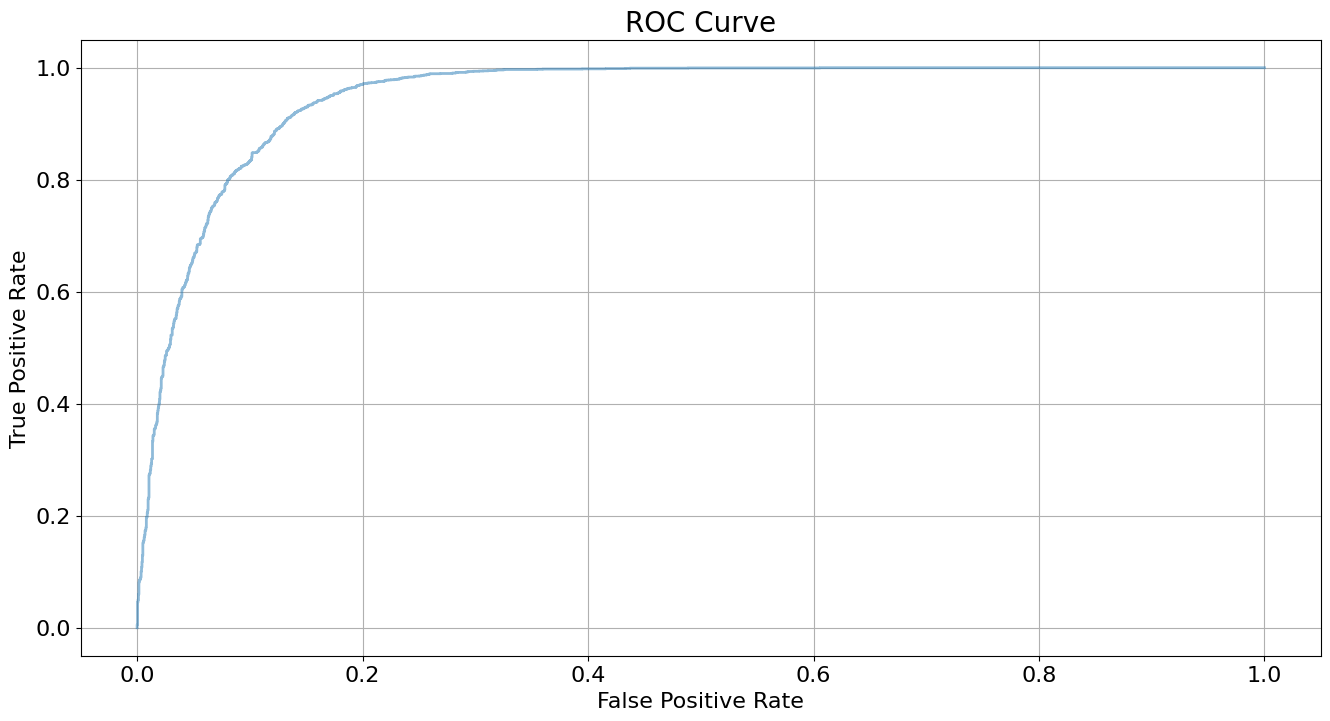

(array([0.        , 0.        , 0.        , ..., 0.99922179, 0.99961089,
        1.        ]),
 array([0.00000000e+00, 3.96825397e-04, 7.93650794e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 9.97363991e-01, 9.96209749e-01, ...,
        2.18390196e-06, 1.24983310e-06, 0.00000000e+00]))

In [56]:
plt.rcParams["figure.figsize"] = (4,4)
get_roc_curve(model, 
              eval_dataset,
              thread_count=-1,
              plot=True)

In [57]:
print(model.get_best_score())


{'learn': {'Accuracy': 0.952580560649725, 'Logloss': 0.14978808128367632, 'AUC': 0.9907826423965779}}


Text(0.5, 0, 'CatBoost Feature Importance')

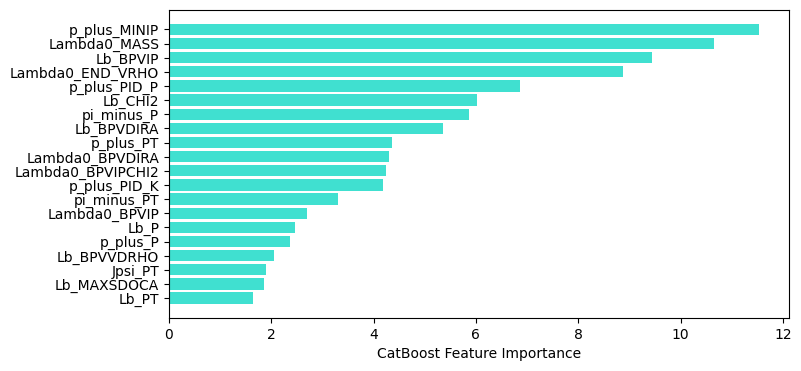

In [58]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (8,4)
plt.barh(X_eval.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [59]:
signal_MVA_prob_eval = model.predict_proba(X_eval_copy)
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_eval]
X_eval_copy['signal_MVA'] = signal_MVA_probs

signal_MVA_prob_tr = model.predict_proba(X_tr_copy)
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_tr]
X_tr_copy['signal_MVA'] = signal_MVA_probs

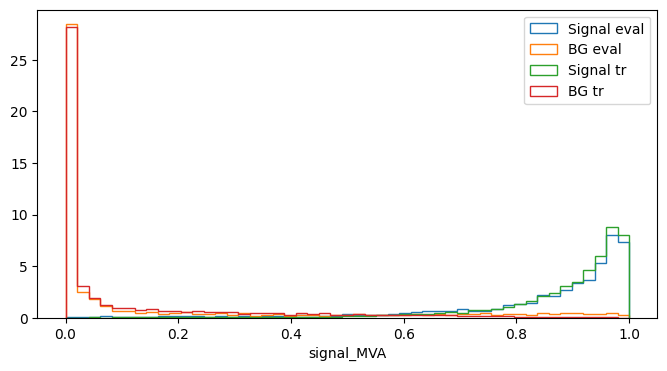

In [60]:
fig, ax = plt.subplots()

density = True

variable = 'signal_MVA'

bins = np.linspace(0,1,50)

n_sig,bins_sig, _ = ax.hist(X_eval_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal eval",histtype='step',density=density)
n_bg,bins_bg, _ = ax.hist(X_eval_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG eval",histtype='step',density=density)

ax.hist(X_tr_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal tr",histtype='step',density=density)
ax.hist(X_tr_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG tr",histtype='step',density=density)

ax.legend()

plt.xlabel(variable)
plt.show()

In [61]:
len(signal_data)

10179

In [83]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=100, max_depth=6, objective='binary:logistic',verbosity=2)
bst.fit(X_tr, y_tr_clean)

[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:51:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nod

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

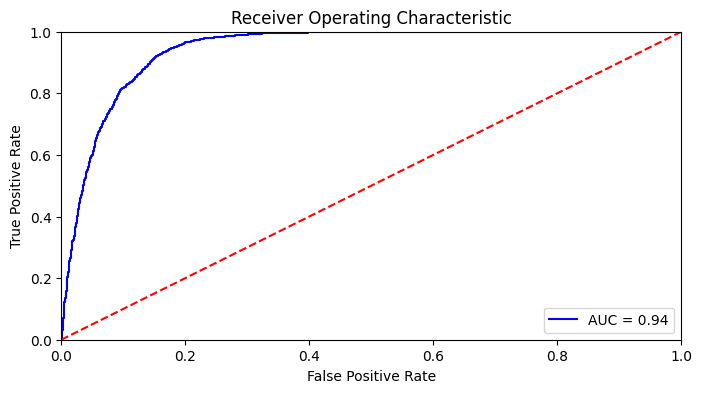

In [84]:
import sklearn.metrics as metrics
probs = bst.predict_proba(X_eval)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_eval, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<BarContainer object of 20 artists>

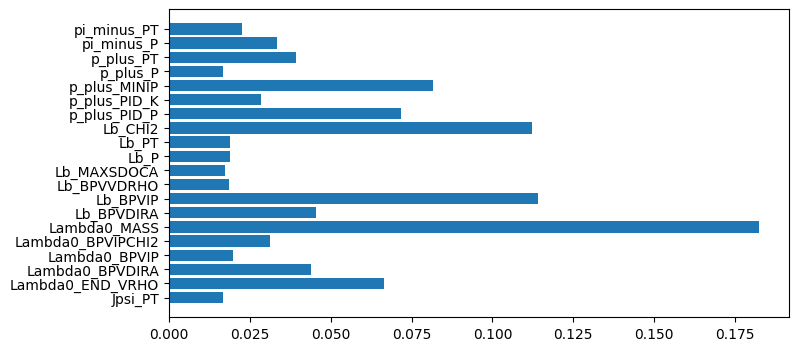

In [85]:
plt.barh(X_eval.columns,bst.feature_importances_)

In [86]:
to_drop_2 = to_drop
to_drop_2.append("xg_boost_signal_MVA")

signal_MVA_prob_eval = bst.predict_proba(X_eval_copy.drop(columns=to_drop_2,inplace=False))
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_eval]
X_eval_copy['xg_boost_signal_MVA'] = signal_MVA_probs

signal_MVA_prob_tr = bst.predict_proba(X_tr_copy.drop(columns=to_drop_2,inplace=False))
signal_MVA_probs = [1 - i[0] for i in signal_MVA_prob_tr]
X_tr_copy['xg_boost_signal_MVA'] = signal_MVA_probs



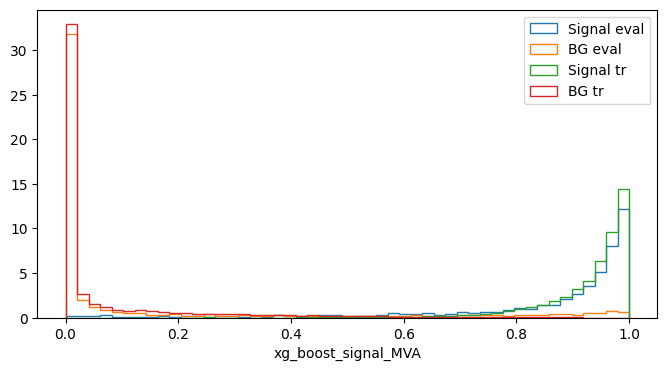

In [87]:
fig, ax = plt.subplots()

density = True

variable = 'xg_boost_signal_MVA'

bins = np.linspace(0,1,50)

n_sig,bins_sig, _ = ax.hist(X_eval_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal eval",histtype='step',density=density)
n_bg,bins_bg, _ = ax.hist(X_eval_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG eval",histtype='step',density=density)

ax.hist(X_tr_copy.query(f'SIGNAL')[variable], bins=bins, linewidth=1 ,label="Signal tr",histtype='step',density=density)
ax.hist(X_tr_copy.query(f'not SIGNAL')[variable], bins=bins, linewidth=1 ,label="BG tr",histtype='step',density=density)

ax.legend()

plt.xlabel(variable)
plt.show()

In [98]:
x = 0.5
len(X_eval_copy.query(f'(xg_boost_signal_MVA > {x}) & not SIGNAL'))/len(X_eval_copy.query('(not SIGNAL)'))


0.15719844357976653